In [1]:
## Example for computing place fields received from Bapun on 2021/11/10
import sys
from pathlib import Path
try:
    from neuropy import core
except ImportError:
    sys.path.append(r'C:\Users\Pho\repos\NeuroPy')
    from neuropy import core

from neuropy.io import NeuroscopeIO, BinarysignalIO
import numpy as np

class ProcessData:
    def __init__(self, basepath):
        basepath = Path(basepath)
        xml_files = sorted(basepath.glob("*.xml"))
        assert len(xml_files) == 1, "Found more than one .xml file"

        fp = xml_files[0].with_suffix("")
        self.filePrefix = fp

        self.recinfo = NeuroscopeIO(xml_files[0])
        self.eegfile = BinarysignalIO(
            self.recinfo.eeg_filename,
            n_channels=self.recinfo.n_channels,
            sampling_rate=self.recinfo.eeg_sampling_rate,
        )

        if self.recinfo.dat_filename.is_file():
            self.datfile = BinarysignalIO(
                self.recinfo.dat_filename,
                n_channels=self.recinfo.n_channels,
                sampling_rate=self.recinfo.dat_sampling_rate,
            )
            
        self.paradigm = core.Epoch.from_file(fp.with_suffix(".paradigm.npy"))
        self.probegroup = core.ProbeGroup.from_file(fp.with_suffix(".probegroup.npy"))
        self.ripple = core.Epoch.from_file(fp.with_suffix(".ripple.npy"))

        if (f := self.filePrefix.with_suffix(".neurons.npy")).is_file():
            d = np.load(f, allow_pickle=True).item()
            self.neurons = core.Neurons.from_dict(d)

        if (f := self.filePrefix.with_suffix(".position.npy")).is_file():
            d = np.load(f, allow_pickle=True).item()
            self.position = core.Position.from_dict(d)

        if (f := self.filePrefix.with_suffix(".maze1.linear.npy")).is_file():
            d = np.load(f, allow_pickle=True).item()
            self.maze1 = core.Position.from_dict(d)


        if (f := self.filePrefix.with_suffix(".maze2.linear.npy")).is_file():
            d = np.load(f, allow_pickle=True).item()
            self.maze2 = core.Position.from_dict(d)






    def __repr__(self) -> str:
        return f"{self.__class__.__name__}({self.recinfo.source_file.name})"


def ratSTwoNovel():
    # basepath='/data/Clustering/sessions/RatS/Day5TwoNovel'
    basepath = 'R:\data\Bapun\Day5TwoNovel'
    return ProcessData(basepath)

# Calculating the placefields

In [2]:
from neuropy.analyses import Pf1D

sess = ratSTwoNovel()
pyr_neurons = sess.neurons.get_neuron_type('pyr')
linearized_pos = sess.maze1
pf = Pf1D(neurons=pyr_neurons,position=linearized_pos,speed_thresh=4,grid_bin=7)

Issue with pickled POSIX_PATH on windows for path R:\data\Bapun\Day5TwoNovel\RatS-Day5TwoNovel-2020-12-04_07-55-09.probegroup.npy, falling back to non-pickled version...


# Plotting place fields

<AxesSubplot:xlabel='Position'>

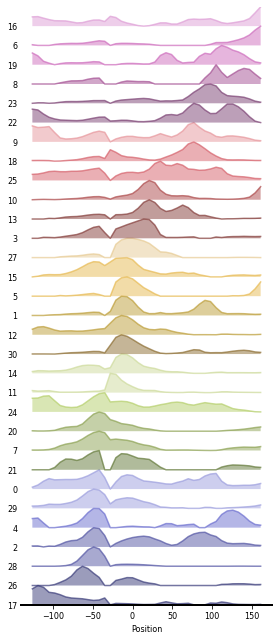

In [3]:
%matplotlib inline

from neuropy import plotting
plotting.plot_ratemap(pf.ratemap,normalize_tuning_curve=True)

# Position decoding

In [ ]:
from neuropy.analyses import Decode1d

maze1 = sess.paradigm['maze1']
rpls = sess.ripple.time_slice(maze1[0],maze1[1])
pf_neurons = pyr_neurons.get_by_id(pf.ratemap.neuron_ids) 
decode = Decode1d(neurons=pf_neurons,ratemap = pf.ratemap,epochs=rpls,bin_size=0.02)

In [ ]:
decode.plot_replay_epochs()